# Nibabel

In [1]:
!pip install nibabel

In [4]:
import nibabel as nib
import matplotlib.pyplot as plt
import os

In [5]:
%pwd

'/home/priyanshu1303d/Projects/Heart_Segmentation/research'

In [6]:
os.chdir("../")

In [7]:
%pwd

'/home/priyanshu1303d/Projects/Heart_Segmentation'

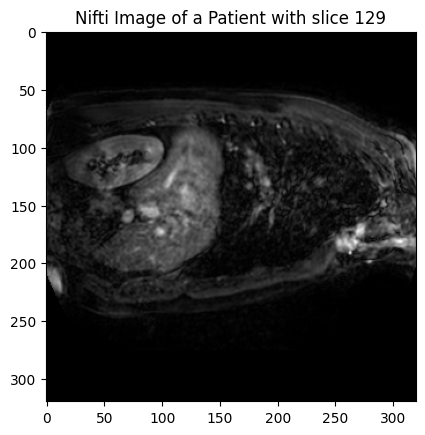

In [14]:
#load the patient path
patient_path = 'artifacts/data_ingestion/imagesTr/la_003.nii.gz'

#load the patient 
nii = nib.load(patient_path)

# convert the 3d image into Frame data i.e 3d array
nii_array = nii.get_fdata()

#plot the slices and take all the X , Y but one slice of Z
# for i in range(5):
#     plt.imshow(nii_array[ : , : , i] , cmap = 'grey',)
#     plt.title(f"Nifti Image of a Patient with slice {i}")
#     plt.show()

plt.imshow(nii_array[ : , : , 129] , cmap = 'grey',)
plt.title(f"Nifti Image of a Patient with slice {129}")
plt.show()

In [9]:
# load the header 
print(nii.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 320 320 130   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.   1.25 1.25 1.37 0.   0.   0.   0.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b''
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1.25 0.   0.

In [10]:
print(f"The shape is: {nii.shape}")
print(f"Voxel size : {nii.header['pixdim']}")
print(f"The Data type is : {nii_array.dtype}")

The shape is: (320, 320, 130)
Voxel size : [1.   1.25 1.25 1.37 0.   0.   0.   0.  ]
The Data type is : float64


In [15]:
import numpy as np

Niiz transformation

In [18]:
nii = nib.load('artifacts/data_ingestion/imagesTr/la_003.nii.gz')

affine = np.array([[1,0,0,0] , [0,1,0,0] , [0,0,1,0] , [0,0,0,1]])

nii.set_qform(affine)

nib.save(nii , 'data/data_transformed.nii.gz')

Preprocessing

In [44]:
import os
from pathlib import Path
from dataclasses import dataclass
from typing import List

@dataclass(frozen=True)
class DataPreprocessingConfig:
    root_dir : Path
    input_dir :  Path
    output_dir : Path
    target_size : List[int]

@dataclass(frozen=True)
class LabelsPreprocessingConfig:
    root_dir: Path
    input_dir: Path
    output_dir: Path
    target_size: List[int]

In [22]:
from src.Heart_Segmentation.constants import *  # Your constants file (e.g., CONFIG_FILE_PATH)
from src.Heart_Segmentation.utils.common import read_yaml, create_directories
from src.Heart_Segmentation import logger

In [47]:
class ConfigurationManager:
    def __init__(self , config_filepath = CONFIG_FILE_PATH , params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_data_preprocessing_config(self) -> DataPreprocessingConfig:
        config = self.config.data_preprocessing

        create_directories([config.root_dir , config.output_dir])


        data_preprocessing_config = DataPreprocessingConfig(
            root_dir= config.root_dir,
            input_dir= config.input_dir,
            output_dir = config.output_dir,
            target_size= config.target_size
        )

        return data_preprocessing_config
    
    def get_labels_preprocessing_config(self) -> LabelsPreprocessingConfig:
        config = self.config.labels_preprocessing
        create_directories([config.root_dir, config.output_dir])
        return LabelsPreprocessingConfig(
            root_dir=config.root_dir,
            input_dir=config.input_dir,
            output_dir=config.output_dir,
            target_size=config.target_size
        )
    
    

In [36]:
from dataclasses import dataclass
from pathlib import Path
import nibabel as nib
import numpy as np
from scipy.ndimage import zoom
from typing import Tuple

In [37]:
class DataPreprocessing:
    def __init__(self, config: DataPreprocessingConfig):
        self.config = config

    def load_nii_file(self, file_path: str) -> Tuple[np.ndarray, nib.Nifti1Image]: 
        '''Load a .nii.gz file and return its data and image object.'''
        img = nib.load(file_path)
        data = img.get_fdata()  # Converts the img object into 3D np array
        logger.info(f"Loaded {file_path} with shape {data.shape}")
        return data, img  

    def normalize(self, data: np.ndarray) -> np.ndarray:  
        """Scale pixel values to 0-1."""
        data_min = np.min(data)
        data_max = np.max(data)
        if data_max - data_min != 0:
            normalized_data = (data - data_min) / (data_max - data_min)
        else:
            normalized_data = data
        logger.info(f"Normalized the data")
        return normalized_data

    def resize(self, data: np.ndarray) -> np.ndarray:
        current_size = data.shape
        zoom_factors = [t / c for t, c in zip(self.config.target_size, current_size)]
        resized_data = zoom(data, zoom_factors, order=1)
        logger.info(f"Resized from {current_size} to {resized_data.shape}")
        return resized_data

    def save_nii_file(self, data: np.ndarray, original_image: nib.Nifti1Image, output_path: str) -> None: 
        new_img = nib.Nifti1Image(data, original_image.affine)
        nib.save(new_img, output_path)
        logger.info(f"Saved the preprocessed file to {output_path}")

    def preprocess_file(self, input_path: str, output_path: str) -> None: 
        data, img = self.load_nii_file(input_path)
        data = self.normalize(data)
        data = self.resize(data)
        self.save_nii_file(data, img, output_path)

    def preprocess_all_files(self) -> None: 
        input_dir = self.config.input_dir
        output_dir = self.config.output_dir
        for filename in os.listdir(input_dir):
            if filename.endswith('.nii.gz'):
                input_path = os.path.join(input_dir, filename)
                output_path = os.path.join(output_dir, filename)
                logger.info(f"Preprocessing {filename}")
                self.preprocess_file(input_path, output_path)
        logger.info("All files preprocessed successfully!")

In [46]:
class LabelsPreprocessing:
    def __init__(self, config: LabelsPreprocessingConfig):
        self.config = config

    def load_nii_file(self, file_path: str) -> Tuple[np.ndarray, nib.Nifti1Image]:
        img = nib.load(file_path)
        data = img.get_fdata()
        logger.info(f"Loaded {file_path} with shape {data.shape}")
        return data, img

    def resize(self, data: np.ndarray) -> np.ndarray:
        current_size = data.shape
        zoom_factors = [t / c for t, c in zip(self.config.target_size, current_size)]
        resized_data = zoom(data, zoom_factors, order=0)  # Nearest-neighbor for labels
        logger.info(f"Resized from {current_size} to {resized_data.shape}")
        return resized_data

    def save_nii_file(self, data: np.ndarray, original_image: nib.Nifti1Image, output_path: str) -> None:
        new_img = nib.Nifti1Image(data, original_image.affine)
        nib.save(new_img, output_path)
        logger.info(f"Saved preprocessed label to {output_path}")

    def preprocess_file(self, input_path: str, output_path: str) -> None:
        data, img = self.load_nii_file(input_path)
        data = self.resize(data)  # No normalization for labels
        self.save_nii_file(data, img, output_path)

    def preprocess_all_files(self) -> None:
        input_dir = self.config.input_dir
        output_dir = self.config.output_dir
        for filename in os.listdir(input_dir):
            if filename.endswith('.nii.gz'):
                input_path = os.path.join(input_dir, filename)
                output_path = os.path.join(output_dir, filename)
                logger.info(f"Preprocessing label {filename}")
                self.preprocess_file(input_path, output_path)
        logger.info("All labels preprocessed successfully!")

In [52]:
try:
    config = ConfigurationManager()
    data_preprocessing_config = config.get_data_preprocessing_config()
    data_preprocesing = DataPreprocessing(data_preprocessing_config)
    data_preprocesing.preprocess_all_files()


    # for labels
    labels_preprocessing_config = ConfigurationManager()
    labels_preprocessing_config = config.get_labels_preprocessing_config()
    labels_preprocessing = LabelsPreprocessing(labels_preprocessing_config)
    labels_preprocessing.preprocess_all_files()
except Exception as e:
    raise e

[2025-03-26 17:21:22,205: INFO: common : yaml file: config/config.yaml loaded successfully]
[2025-03-26 17:21:22,208: INFO: common : yaml file: params.yaml loaded successfully]
[2025-03-26 17:21:22,209: INFO: common : created directory at: artifacts]
[2025-03-26 17:21:22,210: INFO: common : created directory at: artifacts/data_preprocessing]
[2025-03-26 17:21:22,211: INFO: common : created directory at: artifacts/data_preprocessing/preprocessed]
[2025-03-26 17:21:22,212: INFO: 752769610 : Preprocessing la_022.nii.gz]
[2025-03-26 17:21:22,498: INFO: 752769610 : Loaded artifacts/data_ingestion/imagesTr/la_022.nii.gz with shape (320, 320, 110)]
[2025-03-26 17:21:22,562: INFO: 752769610 : Normalized the data]
[2025-03-26 17:21:22,825: INFO: 752769610 : Resized from (320, 320, 110) to (128, 128, 64)]
[2025-03-26 17:21:23,080: INFO: 752769610 : Saved the preprocessed file to artifacts/data_preprocessing/preprocessed/la_022.nii.gz]
[2025-03-26 17:21:23,081: INFO: 752769610 : Preprocessing la_

# Demo

In [30]:
os.listdir('artifacts/data_ingestion/imagesTr')

['._la_029.nii.gz',
 'la_022.nii.gz',
 'la_003.nii.gz',
 'la_019.nii.gz',
 'la_023.nii.gz',
 'la_020.nii.gz',
 'la_014.nii.gz',
 'la_010.nii.gz',
 'la_024.nii.gz',
 'la_021.nii.gz',
 'la_009.nii.gz',
 'la_011.nii.gz',
 'la_007.nii.gz',
 'la_004.nii.gz',
 'la_029.nii.gz',
 'la_016.nii.gz',
 'la_005.nii.gz',
 'la_017.nii.gz',
 'la_018.nii.gz',
 'la_030.nii.gz',
 'la_026.nii.gz']

# Visulatization

Image shape: (128, 128, 64)
Label shape: (128, 128, 64)


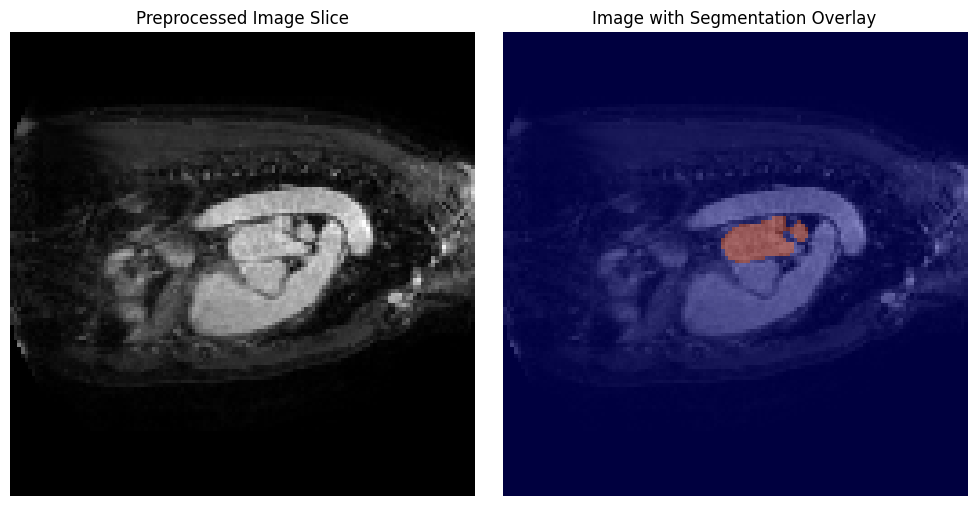

Unique label values in this slice: [0. 1.]


In [54]:
image_path = "artifacts/data_preprocessing/preprocessed/la_003.nii.gz"
label_path = "artifacts/labels_preprocessing/preprocessed/la_003.nii.gz"

# Step 1: Load the preprocessed image and label
image_nii = nib.load(image_path)
label_nii = nib.load(label_path)

image_data = image_nii.get_fdata()  # Shape: (128, 128, 64)
label_data = label_nii.get_fdata()  # Shape: (128, 128, 64)

# Step 2: Check shapes match
print(f"Image shape: {image_data.shape}")
print(f"Label shape: {label_data.shape}")
assert image_data.shape == label_data.shape, "Image and label shapes don’t match!"

# Step 3: Pick a middle slice (e.g., along the depth axis)
slice_idx = image_data.shape[2] // 2  # Middle slice in the depth (z) dimension
image_slice = image_data[:, :, slice_idx]  # 2D slice (128, 128)
label_slice = label_data[:, :, slice_idx]  # 2D slice (128, 128)

# Step 4: Visualize
plt.figure(figsize=(10, 5))

# Subplot 1: Original image slice
plt.subplot(1, 2, 1)
plt.imshow(image_slice, cmap="gray")
plt.title("Preprocessed Image Slice")
plt.axis("off")

# Subplot 2: Image with segmentation overlay
plt.subplot(1, 2, 2)
plt.imshow(image_slice, cmap="gray")  # Background image
plt.imshow(label_slice, cmap="jet", alpha=0.5)  # Overlay label with transparency
plt.title("Image with Segmentation Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()

# Optional: Print unique label values to understand the segmentation
unique_labels = np.unique(label_slice)
print(f"Unique label values in this slice: {unique_labels}")